In [110]:
#Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN, OPTICS
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

In [113]:
customers_df = pd.read_csv('Customers.csv')
transactions_df = pd.read_csv('Transactions.csv')

In [114]:
customers_df.head()

,CustomerID,CustomerName,Region,SignupDate
0,C0001,Lawrence Carroll,South America,2022-07-10
1,C0002,Elizabeth Lutz,Asia,2022-02-13
2,C0003,Michael Rivera,South America,2024-03-07
3,C0004,Kathleen Rodriguez,South America,2022-10-09
4,C0005,Laura Weber,Asia,2022-08-15


In [115]:
transactions_df.head()

,TransactionID,CustomerID,ProductID,TransactionDate,Quantity,TotalValue,Price
0,T00001,C0199,P067,2024-08-25 12:38:23,1,300.68,300.68
1,T00112,C0146,P067,2024-05-27 22:23:54,1,300.68,300.68
2,T00166,C0127,P067,2024-04-25 07:38:55,1,300.68,300.68
3,T00272,C0087,P067,2024-03-26 22:55:37,2,601.36,300.68
4,T00363,C0070,P067,2024-03-21 15:10:10,3,902.04,300.68


In [116]:
# Feature engineering: Aggregate transaction data for each customer
transaction_features = transactions_df.groupby("CustomerID").agg(
    total_spend=('TotalValue', 'sum'),
    avg_spend=('TotalValue', 'mean'),
    total_quantity=('Quantity', 'sum'),
    avg_quantity=('Quantity', 'mean'),
).reset_index()

In [117]:
transaction_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 199 entries, 0 to 198
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   CustomerID      199 non-null    object 
 1   total_spend     199 non-null    float64
 2   avg_spend       199 non-null    float64
 3   total_quantity  199 non-null    int64  
 4   avg_quantity    199 non-null    float64
dtypes: float64(3), int64(1), object(1)
memory usage: 7.9+ KB


In [118]:
max_transaction_value = transactions_df.groupby('CustomerID')['TotalValue'].max()
min_transaction_value = transactions_df.groupby('CustomerID')['TotalValue'].min()
std_transaction_value = transactions_df.groupby('CustomerID')['TotalValue'].std()
num_products = transactions_df.groupby('CustomerID')['ProductID'].nunique()

transactions_df['Month'] = pd.to_datetime(transactions_df['TransactionDate']).dt.month
month_freq = transactions_df.groupby('CustomerID')['Month'].agg(lambda x: x.mode()[0])  # Mode of months

In [121]:
#Feature Engineering
customer_profile = pd.merge(customers_df, transaction_features, on="CustomerID", how="left").dropna()
customer_profile['max_transaction_value'] = customer_profile['CustomerID'].map(max_transaction_value)
customer_profile['min_transaction_value'] = customer_profile['CustomerID'].map(min_transaction_value)
customer_profile['most_common_purchase_month'] = customer_profile['CustomerID'].map(month_freq)

customer_profile = pd.get_dummies(customer_profile, columns=['Region'], drop_first=True)

frequency = transactions_df.groupby('CustomerID')['TransactionID'].count()
customer_profile['frequency'] = customer_profile['CustomerID'].map(frequency)

monetary = transactions_df.groupby('CustomerID')['TotalValue'].mean()
customer_profile['monetary'] = customer_profile['CustomerID'].map(monetary)

customer_profile = customer_profile.drop(columns=['CustomerID', 'CustomerName', 'SignupDate'])

In [136]:
bins = [0, 50, 150, np.inf]
labels = ['Low', 'Medium', 'High']
total_spend = transactions_df.groupby('CustomerID')['TotalValue'].sum()
total_spend_binned = pd.cut(total_spend, bins=bins, labels=labels, right=False)

customer_profile['SpendingCategory'] = total_spend_binned
customer_profile = pd.get_dummies(customer_profile, columns=['SpendingCategory'], drop_first=True)

In [137]:
customer_profile.info()

<class 'pandas.core.frame.DataFrame'>
Index: 199 entries, 0 to 199
Data columns (total 14 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   total_spend                 199 non-null    float64
 1   avg_spend                   199 non-null    float64
 2   total_quantity              199 non-null    float64
 3   avg_quantity                199 non-null    float64
 4   max_transaction_value       199 non-null    float64
 5   min_transaction_value       199 non-null    float64
 6   most_common_purchase_month  199 non-null    int32  
 7   Region_Europe               199 non-null    bool   
 8   Region_North America        199 non-null    bool   
 9   Region_South America        199 non-null    bool   
 10  frequency                   199 non-null    int64  
 11  monetary                    199 non-null    float64
 12  SpendingCategory_Medium     199 non-null    bool   
 13  SpendingCategory_High       199 non-null

In [138]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(customer_profile)

In [139]:
def evaluate_clustering(model, data):
    labels = model.labels_ if hasattr(model, 'labels_') else model.predict(data)
    silhouette = silhouette_score(data, labels)
    db_index = davies_bouldin_score(data, labels)
    return silhouette, db_index

### Clustering Algorithm & Evaluation

In [140]:
kmeans_results = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_features)
    silhouette, db_index = evaluate_clustering(kmeans, scaled_features)
    kmeans_results.append((k, silhouette, db_index))

In [141]:
agg_results = []
linkages = ['ward', 'complete', 'average']
for linkage in linkages:
    agglomerative = AgglomerativeClustering(linkage=linkage)
    agglomerative.fit(scaled_features)
    silhouette, db_index = evaluate_clustering(agglomerative, scaled_features)
    agg_results.append((linkage, silhouette, db_index))

In [142]:
optics_results = []
for min_samples in range(3, 10):
    optics = OPTICS(min_samples=min_samples)
    optics.fit(scaled_features)
    silhouette, db_index = evaluate_clustering(optics, scaled_features)
    optics_results.append((min_samples, silhouette, db_index))

In [143]:
best_kmeans = max(kmeans_results, key=lambda x: x[1])
best_agg = max(agg_results, key=lambda x: x[1])
best_optics = max(optics_results, key=lambda x: x[1])

In [133]:
print(f"K Means: {best_kmeans}, agglomerative:{best_agg}, optics:{best_optics}")

K Means: (4, 0.37991091571305846, 1.176184514784793), agglomerative:('ward', 0.27907558140336225, 1.3155294967842055), optics:(9, 0.03239482446750162, 1.789966262542042)


In [144]:
print(f"K Means: {best_kmeans}, agglomerative:{best_agg}, optics:{best_optics}")

K Means: (4, 0.37991091571305846, 1.176184514784793), agglomerative:('ward', 0.27907558140336225, 1.3155294967842055), optics:(9, 0.03239482446750162, 1.789966262542042)


In [145]:
#Final Model Selection
best_model = KMeans(n_clusters=best_kmeans[0], random_state=42)
best_model.fit(scaled_features)


KMeans(n_clusters=4, random_state=42)

In [146]:
best_model.labels_

array([1, 0, 1, 1, 0, 1, 0, 2, 3, 3, 1, 1, 1, 3, 2, 2, 3, 2, 3, 2, 0, 0,
       3, 2, 1, 2, 0, 0, 2, 2, 1, 1, 2, 2, 2, 2, 3, 2, 1, 0, 3, 2, 0, 3,
       0, 2, 2, 1, 2, 2, 3, 1, 3, 0, 2, 0, 3, 2, 2, 3, 3, 3, 3, 3, 2, 3,
       2, 2, 3, 3, 1, 2, 3, 3, 3, 1, 1, 0, 2, 0, 3, 1, 1, 0, 1, 3, 1, 0,
       3, 0, 1, 0, 0, 2, 1, 1, 0, 2, 1, 3, 0, 1, 3, 1, 3, 0, 1, 1, 2, 0,
       3, 1, 1, 3, 0, 2, 2, 1, 3, 1, 3, 2, 0, 3, 2, 1, 3, 0, 1, 1, 2, 3,
       1, 0, 3, 0, 1, 0, 2, 0, 3, 0, 0, 2, 0, 0, 1, 1, 3, 1, 1, 1, 1, 2,
       1, 2, 2, 1, 0, 2, 0, 0, 1, 3, 1, 3, 3, 1, 1, 3, 1, 3, 0, 1, 0, 2,
       0, 0, 3, 1, 3, 2, 1, 2, 0, 1, 1, 2, 1, 1, 1, 0, 2, 1, 3, 3, 3, 3,
       0], dtype=int32)

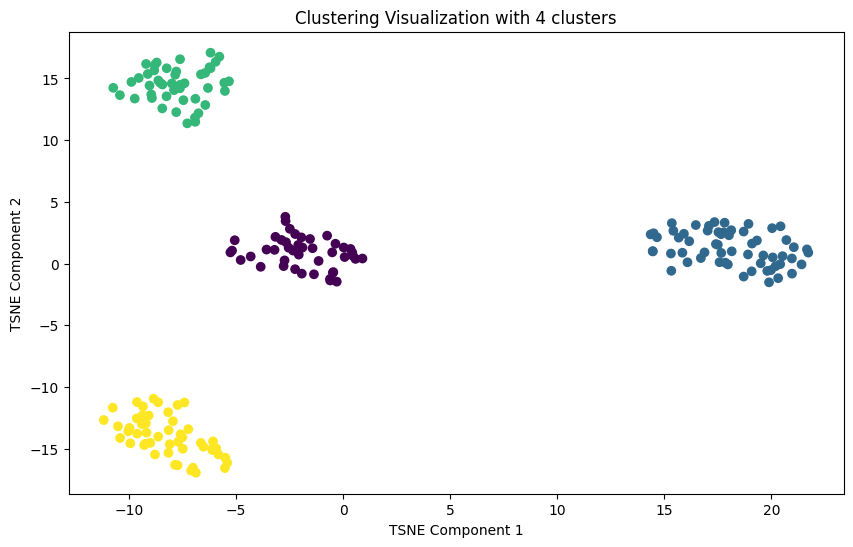

In [147]:
#Reduce dimensions for visualization
tsne = TSNE(n_components=2, random_state=42)
reduced_features = tsne.fit_transform(scaled_features)

plt.figure(figsize=(10, 6))
plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=best_model.labels_, cmap='viridis')
plt.title(f'Clustering Visualization with {best_kmeans[0]} clusters')
plt.xlabel('TSNE Component 1')
plt.ylabel('TSNE Component 2')
plt.show()

In [148]:
print("Clustering Report:")
print(f"Best Clustering Model: KMeans with {best_kmeans[0]} clusters")
print(f"Silhouette Score (KMeans): {best_kmeans[1]}")
print(f"DB Index (KMeans): {best_kmeans[2]}")

Clustering Report:
Best Clustering Model: KMeans with 4 clusters
Silhouette Score (KMeans): 0.37991091571305846
DB Index (KMeans): 1.176184514784793


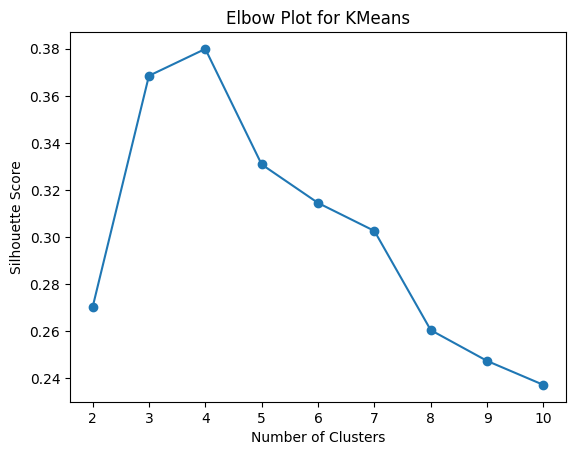

In [149]:
#Elbow Plot
plt.plot(range(2, 11), [result[1] for result in kmeans_results], marker='o')
plt.title('Elbow Plot for KMeans')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.show()